# [NTDS'18] milestone 2: network models
[ntds'18]: https://github.com/mdeff/ntds_2018

[Hermina Petric Maretic](https://people.epfl.ch/hermina.petricmaretic), [EPFL LTS4](https://lts4.epfl.ch)

## Students

* Team: 31
* Students: Dilara Günay, Derin Sinan Bursa, Othman Benchekroun, Sinan Gökçe
* Dataset: IMDb Films and Crew

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* In the first part, you cannot import any other library than we imported. In the second part, you are allowed to import any library you want.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The purpose of this milestone is to explore various random network models, analyse their properties and compare them to your network. In the first part of the milestone you will implement two random graph models and try to fit them to your network. In this part you are not allowed to use any additional package. In the second part of the milestone you will choose a third random graph model that you think shares some properties with your network. You will be allowed to use additional packages to construct this network, but you must explain your network choice. Finally, make your code as clean as possible, and keep your textual answers short.

## Part 0

Import the adjacency matrix of your graph that you constructed in milestone 1, as well as the number of nodes and edges of your network.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# getting adjacency and edges matrices
adjacency = pd.read_csv('data/adjacency.csv')
edges =  pd.read_csv('data/edges.csv')

In [3]:
edges.head()

,Unnamed: 0,0,1
0,0,30485,236696
1,1,30485,98215
2,2,30485,42286
3,3,30485,68278
4,4,30485,65731


In [4]:
#Dropping useless column from adjacency dataframe
adjacency.drop('Unnamed: 0', axis = 1, inplace = True)
adjacency = adjacency.values
np.set_printoptions(suppress = True)
# calculating the number of nodes and edges of our graph
n_nodes =  len(adjacency)
n_edges = len(edges)

In [5]:
n_edges

206391

## Part 1

**For the computation of this part of the milestone you are only allowed to use the packages that have been imported in the cell below.**

In [6]:
%matplotlib inline

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

**Explanation:** The following function creates the Erdös-Renyi graph. The function takes the number of nodes, the edge probability and the optional seed parameter as inputs. It returns the corresponding random Erdos-Renyi graph. The function adds one node at a time to the existing graph and it creates edges between the new and the existing nodes if the probability given (p) is higher than the randomly generated probability. For the sake of minimum computation, the edges are created only for the upper triangle of the adjacency matrix and then it's copied to the lower triangle.

In [7]:
def erdos_renyi(n, p, seed=None):
    
    """Create an instance from the Erdos-Renyi graph model.
    
    Parameters
    ----------
    n: int
        Size of the graph.
    p: float
        Edge probability. A number between 0 and 1.
    seed: int (optional)
        Seed for the random number generator. To get reproducible results.
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    
    #Creating an empty n*n adjacency matrix
    adjacency = np.zeros(shape=(n,n))
    
    #Indices of lower triangle adjacency matrix
    index_lower = np.tril_indices(n,-1)
    
    #Indices of upper triangle adjacency matrix
    index_upper = np.triu_indices(n,1)
    
    #Since the adjacency matrix is symmetric, we compute only the upper triangle part of the adjacency matrix 
    for i in range(n):
        for j in range(i+1,n):
            random.seed(seed)
            r = random.random()               
            if r <= p:
                adjacency[i,j] = 1
            else:
                continue
    
    #Copying the computed upper triangle part of the matrix into the lower triangle 
    #so that the full adjacency matrix is computed
    adjacency[index_lower] = adjacency[index_upper]
    
    return adjacency

Text(0.5, 1.05, 'Erdos-Renyi (5, 0.6)')

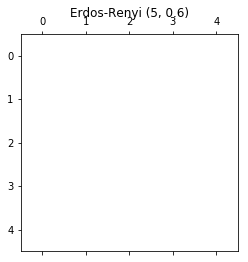

In [8]:
er = erdos_renyi(5, 0.6, 9765) #seed = 9765
plt.spy(er)
plt.title('Erdos-Renyi (5, 0.6)')

Text(0.5, 1.05, 'Erdos-Renyi (10, 0.4)')

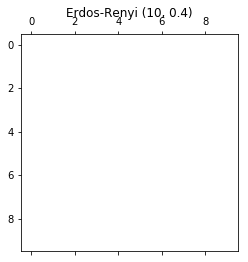

In [9]:
er = erdos_renyi(10, 0.4, 7468) #seed = 7468
plt.spy(er)
plt.title('Erdos-Renyi (10, 0.4)')

### Question 2

Use the function to create a random Erdos-Renyi graph. Choose the parameters such that number of nodes is the same as in your graph, and the number of edges similar. You don't need to set the random seed. Comment on your choice of parameters.

In [10]:
prob = 2*n_edges/(n_nodes*(n_nodes-1)) #Random Networks slide 9/52
print(prob)

0.029112228727151933


Text(0.5, 1.05, 'Erdos-Renyi (10, 0.0291)')

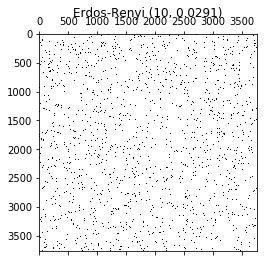

In [11]:
random_er = erdos_renyi(n=n_nodes, p=prob)
plt.spy(random_er)
plt.title('Erdos-Renyi (10, {:.4f})'.format(prob))

In [13]:
edges_erdos = np.count_nonzero(np.triu(random_er))
edges_erdos

206115

**Answer:** Without calculating the edge probability, we first chose a random probability $0.4$ and the random Erdos-Renyi graph resulted in $2835900$ edges which is much bigger than the actual number of edges of our graph ($206391$).

Therefore, the edge probability should be calculated given the number of edges and nodes such that the created random graph gives approximately the same number of edges. The formula used is $prob = 2*\dfrac{n\_edges}{n\_nodes*(n\_nodes-1)}$ and has been taken from the course slides. After replacing the number of edges and nodes in the formula, probability is $0.029112228727151933$.

### Question 3

Create a function that constructs a Barabási-Albert graph.

**Explanation:** The following function creates the Barabasi-Albert graph. It takes the number of nodes, the number of edges to attach from a new node to existing nodes and number of nodes for the initial connected network that is equal to 2 by default. Also, optionally a seed for the random number generator can be given as an input to get reproducible results. It returns the corresponding random Barabasi-Albert graph. In the function itself, firstly an initial connected network is formed with m0 nodes. Later, one more new node is connected to m nodes until there are n number of nodes (given as input) in the connected graph. For the sake of minimum computation, the edges are created only for the upper triangle of the adjacency matrix and then it's copied to the lower triangle.

In [14]:
def barabasi_albert(n, m, m0=2, seed=None):
    """Create an instance from the Barabasi-Albert graph model.
    
    Parameters
    ----------
    n: int
        Size of the graph.
    m: int
        Number of edges to attach from a new node to existing nodes.
    m0: int (optional)
        Number of nodes for the inital connected network.
    seed: int (optional)
        Seed for the random number generator. To get reproducible results.
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """   
    m0 = int(m0)
    random.seed(seed)
    # Add m0 initial nodes
    adjacency = np.zeros(shape=(n,n))
    for k in range(m0):
        for l in range(k+1,m0):
            adjacency[k,l] = 1
            
    # List of existing nodes, with nodes repeated once for each adjacent edge 
    visited_nodes = list(range(m0))
    
    # Target nodes for new edges 
    target = random.sample(range(len(visited_nodes)),m)
    
    # Start adding the other n-m nodes. The first node is m. 
    for i in range(m0, n):
        for j in range(m):
            adjacency[target[j],i] = 1
        visited_nodes.extend([i])
        target = random.sample(range(len(visited_nodes)),m)
    
    adjacency = adjacency + np.transpose(adjacency)
    
    
    return adjacency

Text(0.5, 1.05, 'Barabasi-Albert (5, 1)')

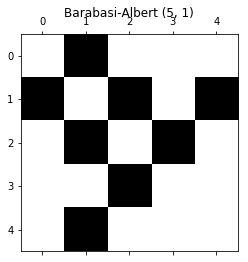

In [15]:
ba = barabasi_albert(5, 1, 2, 9087)
plt.spy(ba)
plt.title('Barabasi-Albert (5, 1)')

Text(0.5, 1.05, 'Barabasi-Albert (10, 2)')

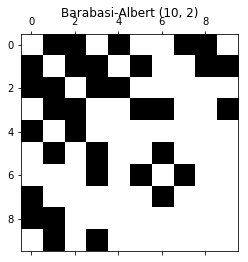

In [16]:
ba = barabasi_albert(10, 2, 3, 8708)
plt.spy(ba)
plt.title('Barabasi-Albert (10, 2)')

### Question 4

Use the function to create a random Barabási-Albert graph. Choose the parameters such that number of nodes is the same as in your graph, and the number of edges similar. You don't need to set the random seed. Comment on your choice of parameters.

In [17]:
n = n_nodes
m = int(n_edges/n_nodes)
m0 = int(n_edges/n_nodes)

Text(0.5, 1.05, 'Barabasi-Albert (10, 54)')

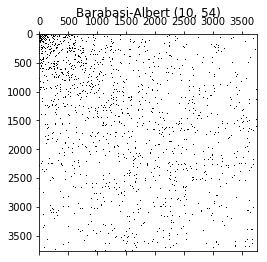

In [18]:
random_ba = barabasi_albert(n, m, m0)
plt.spy(random_ba)
plt.title('Barabasi-Albert (10, {})'.format(m))

In [19]:
edges_barabasi = np.count_nonzero(np.triu(random_ba))
edges_barabasi

201879

**Answer:** Firstly, we chose the $n$ as the original number of nodes of our graph. In a Barabasi-Albert graph, number of edges is equal to $m$ multiplied with number of nodes where $m$ is the number of edges per node. Hence we have chosen the input m as **number of edges/number of nodes**. Additionally, the number of nodes for the initial graph that is $m0$ is also equal to **number of edges/number of nodes**. In the end, we have obtained $201879$ edges where our original number of edges is $206391$. Hence, it could be stated that we have obtained a similar number of edges with these parameters.

### Question 5

Compare the number of edges in all three networks (your real network, the Erdős–Rényi network, and the Barabási-Albert netowk).

In [20]:
print("Number of edges in our network : ", n_edges)
print("Number of edges in the Erdős–Rényi network : ", edges_erdos)
print("Number of edges in the Barabási-Albert network : ", edges_barabasi)

Number of edges in our network :  206391
Number of edges in the Erdős–Rényi network :  206115
Number of edges in the Barabási-Albert network :  201879


### Question 6

Implement a function that computes the [Kullback–Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between two probability distributions.
We'll use it to compare the degree distributions of networks.

In [21]:
def kl_divergence(p, q):
    """Compute the KL divergence between probability distributions of degrees of two networks.
    
    Parameters
    ----------
    p: np.array
        Probability distribution of degrees of the 1st graph.
    q: np.array
        Probability distribution of degrees of the 2nd graph.
    
    Returns
    -------
    kl
        The KL divergence between tmhe two distributions.
    """
    
    assert len(p) == len(q)
    
    kl = 0
    
    for i in range(len(p)):
        kl = kl + (p[i] * np.log(p[i]/q[i]))
    
    return kl

In [22]:
p_test = np.array([0.2, 0.2, 0.2, 0.4])
q_test = np.array([0.3, 0.3, 0.1, 0.3])
kl_divergence(p_test, q_test)

0.09151622184943575

### Question 7: 

Compare the degree distribution of your network to each of the two synthetic ones, in terms of KL divergence.

**Hint:** Make sure you normalise your degree distributions to make them valid probability distributions.

**Hint:** Make sure none of the graphs have disconnected nodes, as KL divergence will not be defined in that case. If that happens with one of the randomly generated networks, you can regenerate it and keep the seed that gives you no disconnected nodes.

**Explanation:** We are using the same methodology for each of the 3 graphs in order to determine the best binnings to calculate the KL divergence. First, we determine the range of values of the graph's degrees ($\texttt{range(i, j)}$). Then, we try to see which values are actually missing in order to bin the degrees together in the best way possible. 

#### Our network :

In [23]:
type(adjacency)

numpy.ndarray

In [24]:
degree_adj = np.count_nonzero(adjacency, axis=1)
unique_adj, counts_adj = np.unique(degree_adj, return_counts=True)
counts_adj = counts_adj / float(n_nodes)
weights_adj = dict(zip(unique_adj, counts_adj))

In [25]:
values_adj = set(range(1, 624))
degrees_adj = set(degree_adj)
print(sorted(values_adj - degrees_adj))

[2, 3, 5, 7, 219, 244, 245, 251, 263, 276, 279, 299, 302, 304, 307, 311, 316, 322, 326, 328, 329, 331, 332, 334, 336, 337, 339, 341, 344, 347, 349, 350, 351, 353, 355, 356, 357, 359, 360, 363, 364, 366, 367, 368, 369, 370, 371, 372, 373, 375, 376, 378, 379, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 395, 396, 398, 399, 400, 401, 403, 404, 405, 406, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 423, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 455, 456, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 54

#### Erdős–Rényi network : 

In [26]:
type(random_er)

numpy.ndarray

In [27]:
degree_er = np.count_nonzero(random_er, axis=1)
unique_er, counts_er = np.unique(degree_er, return_counts=True)
counts_er = counts_er / float(n_nodes)
weights_er = dict(zip(unique_er, counts_er))

In [28]:
values_er = set(range(74, 146))
degrees_er = set(degree_er)
print(sorted(values_er - degrees_er))

[74, 76, 78, 79, 142, 143, 145]


**Explanation:** In this case, we see that the missing values are never consecutive, which means the best binning is through pairs. Moreover, to avoid having $0$ values, we concatenate all the extreme values to the first –_respectively last_– non-null values.

In [29]:
bins_er = [1]+[75+2*i for i in range(36)]+[623]

In [30]:
dist_er = np.histogram(unique_er, weights=counts_er, bins = bins_er)[0]
dist_adj_er = np.histogram(unique_adj, weights=counts_adj, bins = bins_er)[0]

In [31]:
kl_adj_er = kl_divergence(dist_er, dist_adj_er)
print(kl_adj_er)

nan


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


**Answer:** In this case, we have that $KL>1$, meaning the 2 distributions are not similar at all.

#### Barabási-Albert network :

In [32]:
type(random_ba)

numpy.ndarray

In [33]:
degree_ba = np.count_nonzero(random_ba, axis=1)
unique_ba, counts_ba = np.unique(degree_ba, return_counts=True)
counts_ba = counts_ba / float(n_nodes)
weights_ba = dict(zip(unique_ba, counts_ba))

In [34]:
values_ba = set(range(54, 313))
degrees_ba = set(degree_ba)
print(sorted(values_ba - degrees_ba))

[218, 249, 253, 268, 281, 288, 299, 301, 304, 307, 309, 310, 311, 312]


**Explanation:** In this case, we see that there are no missing values in the first range of values. However, we see the resurgence of a high number of consecutive missing values starting from $216$, which is why we choose to concatenate the values in bins of $7$. Once again, we concatenate the extreme values.

In [35]:
bins_ba = [1]+[55+i for i in range(161)]+[216+7*i for i in range(14)]+[623]

In [36]:
dist_ba = np.histogram(unique_ba, weights=counts_ba, bins = bins_ba)[0]
dist_adj_ba = np.histogram(unique_adj, weights=counts_adj, bins = bins_ba)[0]

In [37]:
kl_adj_ba = kl_divergence(dist_ba, dist_adj_ba)
print(kl_adj_ba)

0.27233374342981137


**Answer:** Having such a small KL divergence means that both degree distributions of the graphs are very similar.

### Question 8

Plot the degree distribution historgrams for all three networks. Are they consistent with the KL divergence results? Explain.

Text(0.5, 1.0, 'Degree distribution of our network')

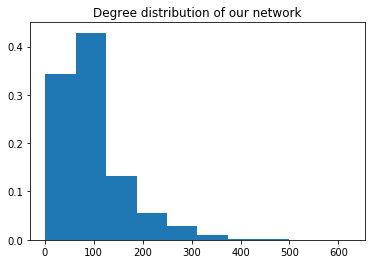

In [38]:
plt.hist(unique_adj, weights=counts_adj)
plt.title('Degree distribution of our network')

Text(0.5, 1.0, 'Degree distribution of the Erdos network')

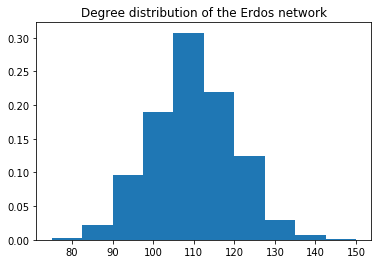

In [39]:
plt.hist(unique_er, weights=counts_er)
plt.title('Degree distribution of the Erdos network')

Text(0.5, 1.0, 'Degree distribution of the Barabasi network')

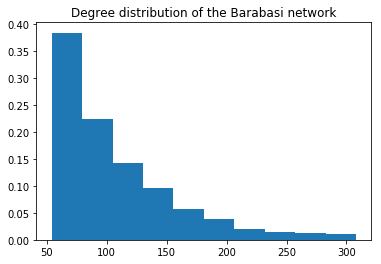

In [40]:
plt.hist(unique_ba, weights=counts_ba)
plt.title('Degree distribution of the Barabasi network')

**Asnwer:** These histograms reflect well the results that we have seen previously. Indeed, the Erdos network has no similarity with our network. However, our network and the Barabasi network share the same degree distribution shape. In this case, it looks a lot like a Poisson distribution.

### Question 9

Imagine you got equal degree distributions. Would that guarantee you got the same graph? Explain.

**Answer:** Even though the degree distribution is identical for both networks, it wouldn't guarantee having the same graph as the same degrees could be associated to different nodes. On top of changing the meaning of the links between the nodes, co-starring actors, this would completely change the topology of the graph.

## Part 2

**You are allowed to use any additional library here (e.g., NetworkX, PyGSP, etc.).** Be careful not to include something here and use it in part 1!

In [41]:
import networkx as nx

### Question 10

Choose a random network model that fits you network well. Explain your choice. 

**Hint:** Check lecture notes for different network models and their properties. Your choice should be made based on at least one property you'd expect to be similar.

**Answer**: We have chosen Watts-Strogatz Random Network Model to better fit our network due to the fact that Watts-Strogatz is a small world model and our IMDB dataset is similar to a small world network in this case. After studying the slides and different random graph models, we expect the clustering coefficient of the Watts-Strogatz model to be the property that would be similar to our original network's value.

Moreover, during our literature research, we have discovered that Watts-Strogatz model was designed specifically for explaining the "small world" phenomena in networks of movie actors.[1]

[1] https://en.wikipedia.org/wiki/Watts%E2%80%93Strogatz_model#Rationale_for_the_model

### Question 11

Explain (in short) how the chosen model works.

**Answer:** The Watts–Strogatz model generates random graphs that has small-world properties. As inputs, it takes the total number of nodes (n), the average node degree (k) and the probability of rewiring each edge (p) with an optional seed for the random number generator. Firstly, a ring is created with the given number of nodes. Then, every node in the ring is connected to k (average node degree) number of other nodes. Later, an existing edge of two nodes, a and b is exchanged with the probability p to new edge between the node a and another existing node other than b. This exchange is iterated for each existing edges. In the end, this model returns the Watts-Strogatz random graph.

### Question 12

Create a random graph from that model, such that the number of nodes is the same as in your graph.

In [43]:
k_real = int(2*n_edges/n_nodes)
m = int(n_edges/n_nodes)
n_edges

206391

In [44]:
G_watts = nx.watts_strogatz_graph(n_nodes, k_real, 0.3)

### Question 13

Check the properties you expected to be similar, and compare to your network.

**Explanation:** In this part we compare the properties of our graph. We defined 3 properties that allow us to compare different models. First property is the number of edges which tells us how many connections are in the networks. The second  is the average degree representing the average number of connection that an actor has. The third one is the average clustering coefficient measuring the degree to which nodes in a graph tend to cluster together. We expect that these properties must be similar to our network

#### Our network :

In [45]:
G = nx.from_numpy_array(adjacency)
print("Number of edges", n_edges)
average_degree_G = sum(dict(G.degree()).values())/n_nodes
print("Average degree", average_degree_G)
average_clustering_G = nx.average_clustering(G)
print("Clustering coefficient", average_clustering_G)

Number of edges 206391
Average degree 98.5246946362188
Clustering coefficient 0.22305771147081796


Text(0.5, 1.0, 'Degree distribution of our network')

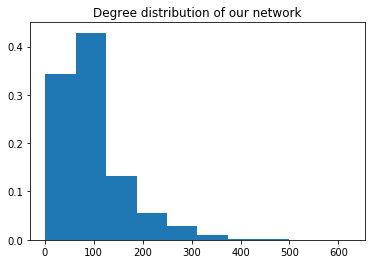

In [46]:
plt.hist(unique_adj, weights=counts_adj)
plt.title('Degree distribution of our network')

#### Watts-Strogatz network :

In [47]:
print("Number of edges : ",G_watts.number_of_edges())
average_degree_watts = sum(dict(G_watts.degree()).values())/n_nodes
print("Average degree : ", average_degree_watts)
average_clustering_G_watts = nx.average_clustering(G_watts)
print("Clustering coefficient",average_clustering_G_watts)

Number of edges :  203364
Average degree :  108.0
Clustering coefficient 0.2648445657598127


Text(0.5, 1.0, 'Degree distribution of the Watts-Strogatz network')

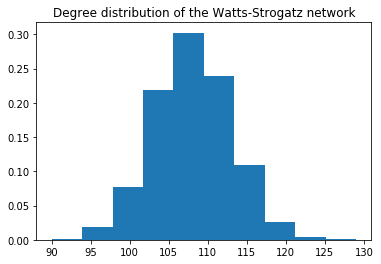

In [48]:
unique_watts, counts_watts = np.unique(list(dict(G_watts.degree()).values()), return_counts=True)
counts_watts = counts_watts / float(n_nodes)
plt.hist(list(unique_watts), weights=counts_watts)
plt.title('Degree distribution of the Watts-Strogatz network')

**Explanation**: The Watts-Strogatz model shows similar properties to our network.

In [49]:
print("Error in number of edges : ", abs(float(G_watts.number_of_edges()-n_edges)/n_edges))
print("Error in average degree : ", abs(float(average_degree_watts-average_degree_G))/float(average_degree_G))
print("Error in Clustering coefficient : ", abs(average_clustering_G-average_clustering_G_watts)/average_clustering_G)

Error in number of edges :  0.014666337194935826
Error in average degree :  0.09617188257996359
Error in Clustering coefficient :  0.1873365149021606


**Explanation**: We can see that the error in the Watts-Strogatz is small for the number of edges and the average degree. However there is a 20% variance in the clustering coefficient values. We can also see from the plot that the degree distribution is more constrained than our network. For example in our movie network we have a distribution that varies from 4 to 623 whereas in the Watts model we obtain a range between 75 and 145.

#### Barabasi-Albert network :

In [50]:
G_barabasi = nx.from_numpy_array(random_ba)
print("Number of edges", edges_barabasi)
average_degree_Barabasi = sum(dict(G_barabasi.degree()).values())/n_nodes
print("Average degree", average_degree_Barabasi)
average_clustering_barabasi = nx.average_clustering(G_barabasi)
print("Clustering coefficient", average_clustering_barabasi)

Number of edges 201879
Average degree 107.2113648433351
Clustering coefficient 0.04226331289605147


Text(0.5, 1.0, 'Degree distribution of our network')

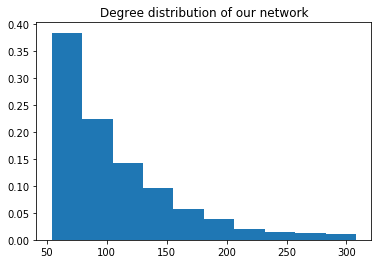

In [51]:
plt.hist(unique_ba, weights=counts_ba)
plt.title('Degree distribution of our network')

In [52]:
print("Error in number of edges : ", abs(float(edges_barabasi-n_edges)/n_edges))
print("Error in average degree : ", abs(float(average_degree_Barabasi-average_degree_G))/float(average_degree_G))
print("Error in Clustering coefficient : ", abs(average_clustering_G-average_clustering_barabasi)/average_clustering_G)

Error in number of edges :  0.02186141837580127
Error in average degree :  0.08816744105820339
Error in Clustering coefficient :  0.810527452212381


**Explanation**: We can see that the error in the the number of edges and the average degree is similar between the Barabasi-Albert model and the Watts-Strogatz model. However there is a big difference in the clustering coefficient values. We can see from the plot that the degree distribution is less constrained than the watts model and closer to our real network.

Are the results what you expected? Explain.

**Explanation:** We expected both Barabasi-Albert and Watts-Strogatz to show good fit. On one side our model represent to a certain degree small world properties where most nodes can be reached with a small number of steps. We can see that property from the clustering coefficient. On the otherside our model also shows a powerlaw behavior of scale free networks where there is increasingly less chance of co-starring with other actors. As such we expected that both these models would explain certain characteristics of our network.